# mocksurvey.py

# Prerequisites
### for halotools:
    - numpy (check with `pip show numpy`)
    - g++ (check with `g++ --version`)
### for Corrfunc:
    - numpy
    - gcc (check with `gcc --version`)
    - gsl (check with `gsl-config --version`)

# Installation
```
git clone https://github.com/AlanPearl/mocksurvey
cd mocksurvey
python setup.py install
bash get_smdpl
```

Tutorial
======

In [1]:
import mocksurvey as ms
import numpy as np
import matplotlib.pyplot as plt

______________________
Classes:
==========
______________________

### Instantiate a SimBox (simulation box -- the source of all model data)

- Given simulation name/redshift, SimBox will grab the halo data
- Given HOD / Subhalo / CLF model name, SimBox can use that model to populate galaxies over the halos via `SimBox.populate_mock()`

In [ ]:
simbox = ms.SimBox(populate_on_instantiation=False);
simbox.populate_mock()

### Instantiate a MockField (observation of SimBox populated galaxies)

- Given a SimBox coordinate `center`, field shape `scheme` (`"circ"`, `"sq"`, or `"hex"`), and field size `sqdeg`, selects galaxies in that field
- Access data through `get_data()`, `get_rands()`, or `get_redshift()`

In [ ]:
field = simbox.field(scheme="hex", sqdeg=1.5)

field.make_rands(density_factor=100)
ms.tp.plot_pos_scatter(field)
# plt.scatter(field.get_rands()[:,0], field.get_rands()[:,2], s=1);

### Instantiate a MockSurvey (set of MockField instances)

- Give the usual MockField arguments (`center`, `scheme`, `sqdeg` etc.), in addition to `rdz_centers`
- Each element of `rdz_centers` must be an array-like object, of shape (2,) or (3,) specifying the (ra,dec) or (ra,dec,z) of each field's center
- **If the z center of a field is given, it is ignored**

### Define some functions to calculate clustering statistics

- $\xi(r)$: `xi_r(data, rands, rbins, ...)`
- $\xi(r_{\rm p}, \pi)$: `xi_rp_pi(data, rands, rpbins, pibins, ...)`
- $w_{\rm p}(r_{\rm p})$: `wp_rp(data, rands, rpbins, ...)`
- $b_{\rm g}(r_{\rm p})$: `bias_rp(data, rands, rpbinses, ...)`

______________________
PFS Plots:
======
______________________

In [2]:
simbox = ms.SimBox(hodname="hearin15", threshold=10.5, redshift=1.35, Nbox=(1,1,3))
field = simbox.field(scheme="hex", sqdeg=1.5, collision_fraction=0.3, delta_z=.7)

/home/alan/local/anaconda3/lib/python3.7/site-packages/halotools-0.6-py3.7-linux-x86_64.egg/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/alan/local/anaconda3/lib/python3.7/site-packages/halotools-0.6-py3.7-linux-x86_64.egg/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[

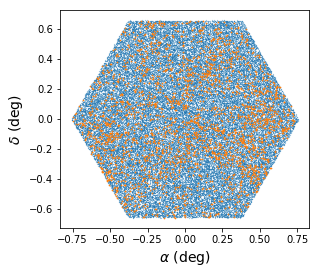

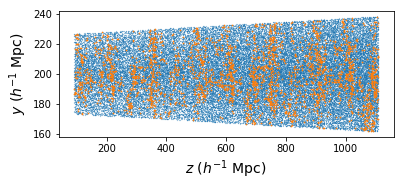

In [3]:
fig,ax = plt.subplots()
ax.set_aspect('equal', 'box')
ms.tp.plot_sky_scatter(field, s=.5)
# plt.savefig("PFS-field-sky.png", bbox_inches="tight")
plt.show()

fig,ax = plt.subplots()
ax.set_aspect(5., 'box')
ms.tp.plot_pos_scatter(field, s=.5, axes=[2,1])
# plt.savefig("PFS-field-pos.png", bbox_inches="tight")
plt.show()

______________________
Correlation Function Plotting:
======
______________________

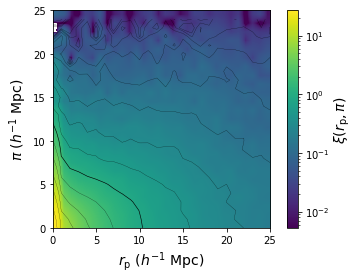

In [6]:
fullbox = simbox.boxfield()
ms.tp.plot_xi_rp_pi(fullbox)
# plt.savefig("fullbox-xi-rp-pi.png", bbox_inches="tight")
plt.show()

______________________
HOD Moments/Occupation Plots:
======
______________________

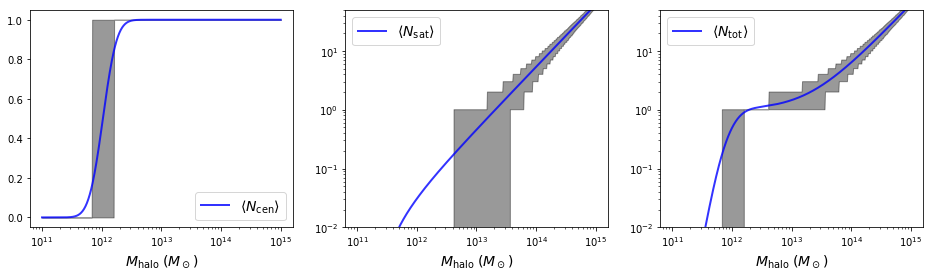

In [5]:
simbox = ms.GalBox(hodname="zheng07", threshold=-20)
ms.tp.plot_hod_occupation(simbox)
# plt.savefig("zheng-occupation-threshold-20.png", bbox_inches="tight")
plt.show()

# Runtime testing 

### List of expensive functions -- tested with SMDPL halos at z=1.35, Zheng07, threshold=-20?

- `ms.cf.paircount_rp_pi()`/`cf.paircount_r()`
    - Wrapper for the extremely well-optimized function `Corrfunc.theory.DD`.
    - Runtime is usually quick, but can be still be VERY long for large/dense sets of galaxies.
    - Can be sped up by passing the `precomputed=(DD,DR,RR)` argument.
    - Alternatively, use `cf.wp_rp` with `rands=None` and specify the `boxsize` if the geometry is a perfect cube
- `ms.SimBox.populate_mock()` 
    - Runtime (~800 ms for Zheng07, ~4 s for Hearin15) depends on number of halos.
    - Can be sped up via the `masking_function` agument (see `SimBox.get_halo_masking_function()`).
    - Sped up times with precomputed selection over 15 sqdeg field (selection takes ~200 ms): ~350 ms for Zheng07, ~1 s for Hearin15.
- `ms.hf.ra_dec_z()`
    - Runtime is generally around ~18 ms (zprec $\geq$ 1e-3) or ~61 ms (zprec = 1e-4), but takes slightly longer for higher redshift.
    - `hf.distance2redshift()` -> `cosmo.comoving_distance()` is the culprit. If too slow, reduce `zprec` to lose redshift precision.
    - This may also be sped up significantly from the previously mentioned `masking_function` argument because there will be fewer galaxies to select from.

______________________
TO DO:
======
______________________

### Test sources of error
- Poisson error of the...
    - Data
    - Randoms
    - this test requires repopulating data ***or*** randoms over a ***single*** field of halos
- Sampling error (i.e. cosmic variance) of the...
    - Field, either...
        - universally: no overlapping fields so they are ~independent of halos
        - ~~with respect to simbox: allowing overlapping fields~~
        - this test inherently contains Poisson error terms, which must be subtracted out in quadrature
    - ~~Simulation box (would be required if we allowed for overlapping fields, but we aren't)~~

### Calibrate bootstrap

According to Norberg et al. (2008), bootstraps overestimate the uncertainty by 40-50% on all scales. This is roughly consistent with what I have found.

Their suggestion is to select $3\times$ more data per random resampling. So instead of $N_{\rm r} = N_{\rm sub}$, use $N_{\rm r} = 3N_{\rm sub}$